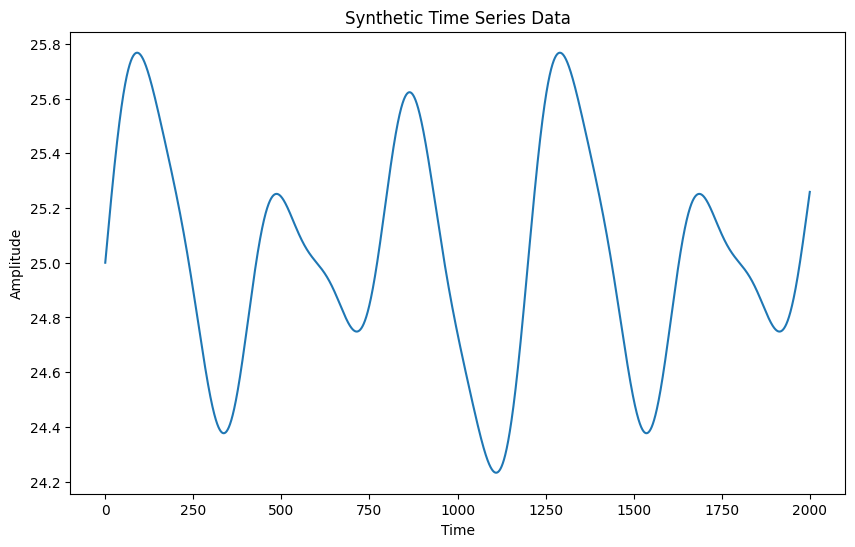

In [16]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData
from myTimedistributed import TimeDistributed

# 데이터 준비
all_data = []

# 주기와 진폭 설정
periods = [10, 20, 30]  # 주기
amplitudes = [0.1, 0.5, 0.3]  # 진폭

# 데이터 생성
time = np.arange(0, 2000, 0.1)  # 시간 범위
data = np.zeros_like(time)  # 데이터 배열 초기화

for period, amplitude in zip(periods, amplitudes):
    data += amplitude * np.sin(np.pi/10 * time / period)
data = data + 25
all_data.append(data)

# 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(time, data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Synthetic Time Series Data')
plt.show()

In [17]:
# 모델 정의 및 학습 --------------------------------------
# 모델 구성

class DoubleConv(nn.Module):
    # 반복되는 Convolution, Batch Normalization, ReLU 모듈화
    def __init__(self, in_channel, out_channel):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels=in_channel, out_channels=out_channel, kernel_size=3,
                      padding=1),
            nn.BatchNorm1d(num_features=out_channel),
            nn.ReLU(),
            nn.Conv1d(in_channels=out_channel, out_channels=out_channel, kernel_size=3,
                      padding=1),
            nn.BatchNorm1d(num_features=out_channel),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    # Down Sampling 진행, 채널이 2배씩 증가한다.
    def __init__(self, in_channel, out_channel):
        super(Down,self ).__init__()
        self.DConv = DoubleConv(in_channel, out_channel)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        
    def forward(self, x):
        skip = self.DConv(x)
        return skip, self.maxpool(skip)

class Up(nn.Module):
    # Up Sampling 진행, 채널이 절반으로 감소.
    def __init__(self, in_channel, out_channel):
        super(Up, self).__init__()
        self.DConv = DoubleConv(in_channel, out_channel)
        self.upsample = nn.ConvTranspose1d(in_channels=out_channel, out_channels=out_channel//2, 
                                           kernel_size=2, stride=2, bias=True)

    def forward(self, x):
        x = self.DConv(x)
        print(x.shape)
        return self.upsample(x)

class UNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        self.down1 = Down(in_channel, out_channel)  # 1 -> 16
        self.down2 = Down(out_channel, out_channel * 2) # 16 -> 32
        self.down3 = Down(out_channel * 2, out_channel * 2**2)  # 32 -> 64 
        self.down4 = Down(out_channel * 2**2, out_channel * 2**3)  # 64 -> 128
        
        self.down5 = DoubleConv(out_channel * 2**3, out_channel * 2**4)  # 128 -> 256
        self.unpool = nn.ConvTranspose1d(in_channels = out_channel * 2**4, out_channels = out_channel * 2**3, 
                                         kernel_size=2, stride=2, bias=True)

        self.up1 = Up(out_channel * 2**4, out_channel * 2**3)   # 256 -> 128
        self.up2 = Up(out_channel * 2**3, out_channel * 2**2)   # 128 -> 64
        self.up3 = Up(out_channel * 2**2, out_channel * 2**1)   # 64 -> 32
        self.up4 = DoubleConv(out_channel * 2**1, out_channel)  # 32 -> 16
        self.up5 = nn.Conv1d(in_channels=out_channel, out_channels=in_channel, kernel_size=3, padding=1)   # 16 -> 1
    
    def forward(self, x):
        # Down Sampling 과정
        x1, x = self.down1(x)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)

        # Down Sampling 종료, Up sampling을 위한 마지막 컨벌루전
        x = self.down5(x)
        print(x.shape)
        x = self.unpool(x)
        # Up sampling 과정
        # Skip Connection 구현. Down sampling애서의 각 feature map을 가져와 붙여준뒤
        # 깉이 디코딩 작업을 하여 데이터의 Localization 정보를 보존한다.
        print(x.shape)
        print('======================')

        x = torch.cat((x4, x), dim = 1)
        print(x.shape)
        x = self.up1(x)
        print(x.shape)
        print('======================')

        x = torch.cat((x3, x), dim = 1)
        print(x.shape)
        x = self.up2(x)
        print(x.shape)
        print('======================')

        x = torch.cat((x2, x), dim = 1)
        print(x.shape)
        x = self.up3(x)
        print(x.shape)
        print('======================')

        x = torch.cat((x1, x), dim = 1)
        print(x.shape)
        x = self.up4(x)
        print(x.shape)
        print('======================')

        x = self.up5(x)
        print(x.shape)
        return x

sequence_length = 240  # 시퀀스 길이 설정
input_size = 1  # 변수 개수
hidden_size = 16
batch_size = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = UNet(input_size, hidden_size).to(device)
# 손실 함수 정의
loss_function = nn.MSELoss()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)


cuda:0


In [18]:

# K-fold Cross Validation
k = 1  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []
rebuild_result = [[],[],[]]
# K-fold data splitting
for i in range(k):
    print(f"Fold {i+1}")
    train_subset_dataloader, test_subset_dataloader = myProcessData(
        all_data, len(all_data), batch_size, sequence_length)
    # ------------------------------------------------------------

    # 모델 초기화
    model = UNet(input_size, hidden_size).to(device)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 학습
    fold_loss = []
    num_epochs = 100  # 학습 횟수 설정
    for epoch in range(num_epochs):
        print(f"epochs: {epoch}")
        for data in train_subset_dataloader:
            
            # 순전파
            optimizer.zero_grad()
            data = data.to(device)
            outputs = model(data)

            # 각 기체별 loss 따로 뽑아서 loss_list에 저장
            loss_list = []
            for loss_count in range(input_size):
                loss = loss_function(outputs[:,0,loss_count].reshape(-1, 1), data[:,0,loss_count].reshape(-1, 1))
                loss_list.append(loss)
            
            # 전체 loss 역전파
            print(outputs.shape)
            loss = loss_function(outputs.reshape(-1, input_size), data.reshape(-1, input_size))
            loss.backward()
            optimizer.step()
            if epoch == num_epochs - 1 :
                for i in range(input_size):
                    rebuild_result[i].append(outputs[:,i,:])
        fold_loss.append(loss_list)

    test_subset_loss = []
    # 테스트 데이터에 대한 재구성 오차 계산
    with torch.no_grad():
        for data in test_subset_dataloader:
            data = data.to(device)
            test_subset_outputs = model(data)
            test_subset_loss.append(loss_function(test_subset_outputs, data))

    # Append the average test loss to test_losses list
    print(f"Loss after training: {fold_loss[-1]}")
    print(f"Fold {i+1} Test loss: {test_subset_loss}")
    print('===========================================================')


Fold 1
15840
epochs: 0
torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 240])
torch.Size([16, 32, 240])
torch.Size([16, 16, 240])
torch.Size([16, 1, 240])
torch.Size([16, 1, 240])
torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 240])
torch.Size([16, 32, 240])
torch.Size([16, 16, 240])
torch.Size([16, 1, 240])
torch.Size([16, 1, 240])
torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])

In [19]:
print(outputs.shape)

torch.Size([16, 1, 240])


In [20]:
# 0번 인덱스 - 온도
print(len(rebuild_result[0]))
temp_rebuild = rebuild_result[0]

# CUDA -> CPU 복원오차 추출
temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
# 그래프 그리기 위한 전처리
temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))


4


In [21]:
temp_data = all_data[0][:len(temp_rebuild)]
temp_min = np.min(temp_data)
temp_max = np.max(temp_data)
temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min


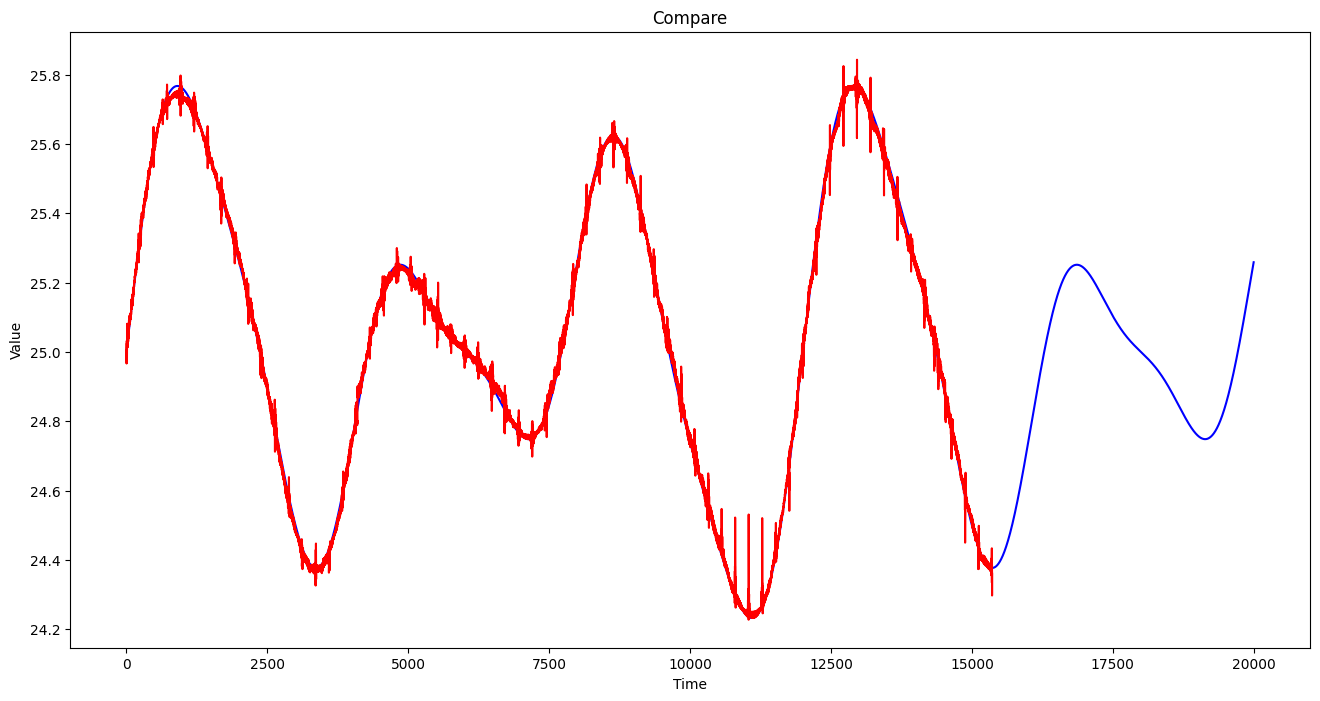

In [22]:

fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
axes.plot(range(len(all_data[0])), all_data[0][:len(all_data[0])], 'b', label="Original")
axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
axes.set_xlabel('Time')
axes.set_ylabel('Value')
axes.set_title('Compare')
plt.show()

# temp_rebuild = rebuild_result[1] # 습도
# temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
# temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))
# temp_data = all_data[1][:len(temp_rebuild)]
# temp_min = np.min(temp_data)
# temp_max = np.max(temp_data)
# temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min

# fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
# axes.plot(range(len(temp_rebuild)), all_data[1][:len(temp_rebuild)], 'b', label="Original")
# axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
# axes.set_xlabel('Time')
# axes.set_ylabel('Value')
# axes.set_title('Compare')
# plt.show()

# temp_rebuild = rebuild_result[2] # Ammonia
# temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in temp_rebuild]
# temp_rebuild = np.reshape(temp_rebuild_cpu, (-1, 1))
# temp_data = all_data[2][:len(temp_rebuild)]
# temp_min = np.min(temp_data)
# temp_max = np.max(temp_data)
# temp_rebuild = (temp_max - temp_min) * temp_rebuild + temp_min

# fig, axes = plt.subplots(figsize=(16, 8), sharex=True)
# axes.plot(range(len(temp_rebuild)), all_data[2][:len(temp_rebuild)], 'b', label="Original")
# axes.plot(range(len(temp_rebuild)), temp_rebuild, 'r', label="Reconstruct")
# axes.set_xlabel('Time')
# axes.set_ylabel('Value')
# axes.set_title('Compare')
plt.show()

In [23]:
# print(test_losses)
# test_losses_cpu = []
# for sublist in test_losses:
#     cpu_sublist = [tensor.cpu() for tensor in sublist]
#     test_losses_cpu.append(cpu_sublist)
# test_losses_cpu = [[tensor.item() for tensor in sublist] for sublist in test_losses_cpu]
# test_losses_cpu = np.reshape(test_losses_cpu, -1)
# print(test_losses_cpu)
# fig, ax = plt.subplots(figsize=(16, 6))
# ax.bar(range(len(test_losses_cpu)), test_losses_cpu, width=0.5, align='center', color='k')
# plt.title('Training Loss for Test Data')
# plt.show()

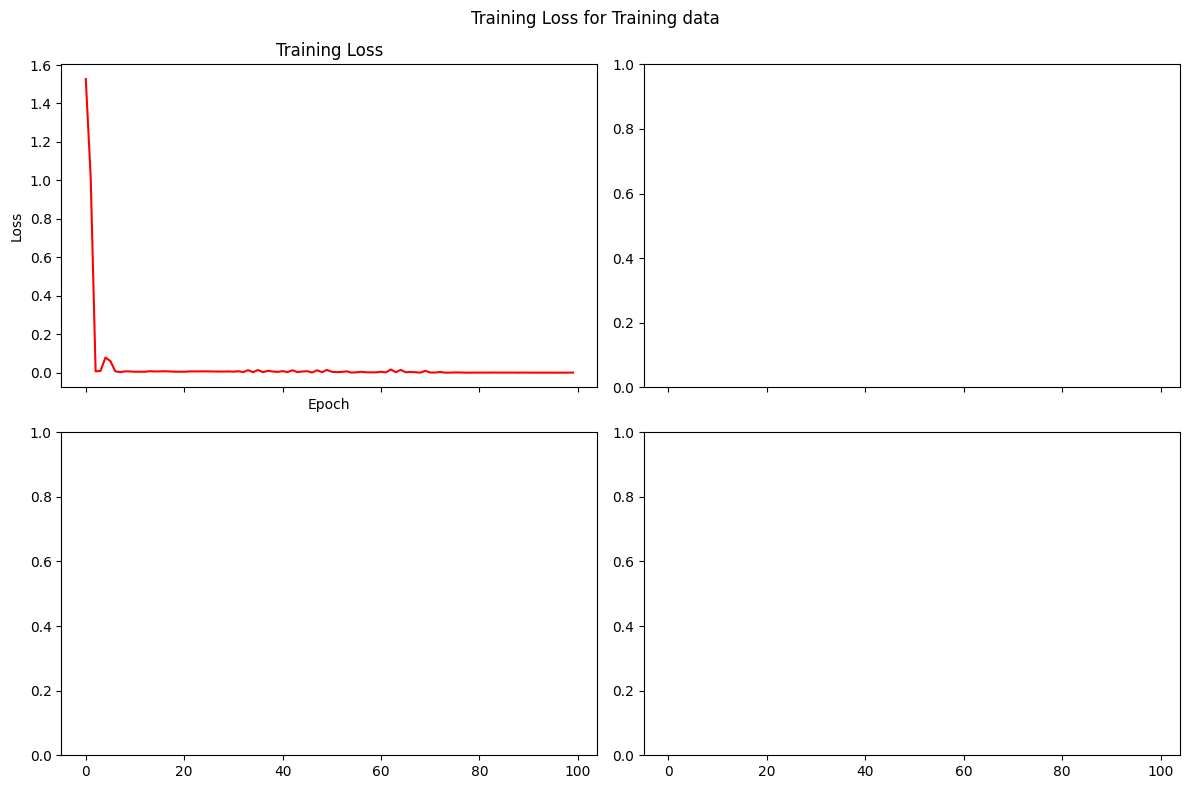

In [24]:
# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
temp_loss = []
humid_loss = []
ammonia_loss = []

for i in range(len(fold_loss)):
    temp_loss.append(fold_loss[i][0])
    # humid_loss.append(fold_loss[i][1])
    # ammonia_loss.append(fold_loss[i][2])

temp_loss = [tensor.detach().cpu().numpy() for tensor in temp_loss]
# humid_loss = [tensor.detach().cpu().numpy() for tensor in humid_loss]
# ammonia_loss = [tensor.detach().cpu().numpy() for tensor in ammonia_loss]

axes[0, 0].plot(range(len(temp_loss)), temp_loss, 'r', label="Temperature loss")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss')

# axes[0, 1].plot(range(len(temp_loss)), temp_loss, 'b', label="Humidity loss")
# axes[0, 1].set_xlabel('Epoch')
# axes[0, 1].set_ylabel('Loss')
# axes[0, 1].set_title('Training Loss')

# axes[1, 0].plot(range(len(temp_loss)), temp_loss, 'k', label="Ammonia loss")
# axes[1, 0].set_xlabel('Epoch')
# axes[1, 0].set_ylabel('Loss')
# axes[1, 0].set_title('Training Loss')
plt.suptitle('Training Loss for Training data')
plt.tight_layout()
plt.show()


In [67]:
# 비정상 데이터 생성 =======================================
# 데이터 파일 불러오기
# abnormal_data = []
# data = pd.read_csv('csv/pjh_multi_data.csv')
# abnormal_data.append(data['temperature'].values)
# abnormal_data.append(data['humidity'].values)
# abnormal_data.append(data['ammonia'].values)
# 주기와 진폭 설정
periods = [10, 20, 30]  # 주기
amplitudes = [0.1, 0.5, 0.3]  # 진폭

# 데이터 생성
time = np.arange(0, 4000, 0.1)  # 시간 범위
data = np.zeros_like(time)  # 데이터 배열 초기화
abnormal_data = 0
for period, amplitude in zip(periods, amplitudes):
    abnormal_data += amplitude * np.sin(np.pi/10 * time / period)
abnormal_data = abnormal_data + 25

# # Noise case 1 : 정현파 노이즈
# X=np.linspace(0,4*np.pi,len(abnormal_data))
# sin_wave=np.sin(X)
# abnormal_data += -sin_wave

# Noise case 2 : 특정 구간 랜덤 노이즈
start_index = 12000
end_index = 12350
interval_length = end_index - start_index
noise = np.random.uniform(-0.5, 0.5, interval_length)
abnormal_data[start_index:end_index] += noise
# abnormal_data[1][start_index:end_index] += 10*noise
# abnormal_data[2][start_index:end_index] += noise

start_index = 1500
end_index = 1550
interval_length = end_index - start_index
noise = np.random.uniform(-0.5, 0.5, interval_length)
# abnormal_data[0][start_index:end_index] += noise
# abnormal_data[1][start_index:end_index] += noise
# abnormal_data[2][start_index:end_index] += noise

# Normalization X -> Standardization
# abnormal_max = np.max(abnormal_data)
# abnormal_min = np.min(abnormal_data)
# abnormal_data = (abnormal_data - abnormal_min) / (abnormal_max - abnormal_min)

# abnormal_max = np.max(abnormal_data[1])
# abnormal_min = np.min(abnormal_data[1])
# abnormal_data[1] = (abnormal_data[1] - abnormal_min) / (abnormal_max - abnormal_min)

# abnormal_max = np.max(abnormal_data[2])
# abnormal_min = np.min(abnormal_data[2])
# abnormal_data[2] = (abnormal_data[2] - abnormal_min) / (abnormal_max - abnormal_min)


In [68]:

# # 3D로 변환
# abnormal_data = np.transpose(np.array(abnormal_data))
# abnormal_dataset = np.reshape(abnormal_data[:np.prod( (int(np.floor(len(abnormal_data)/input_size)), input_size) )], 
#                               (-1, 1, input_size))
# # PyTorch 데이터셋 생성
# abnormal_dataset = torch.Tensor(abnormal_dataset)
# abnormal_dataloader = DataLoader(abnormal_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
all_abnormal_data = []
abnormal_data = np.array(abnormal_data)
abnormal_data = abnormal_data.tolist()
all_abnormal_data.append(abnormal_data)
# abnormal_dataloader, _ = myProcessData(
#         all_abnormal_data, input_size, batch_size, sequence_length)

train_max = np.max(all_data[0])
train_min = np.min(all_data[0])
abnormal_data_test = (abnormal_data - train_min) / (train_max - train_min)
limited_length = (len(abnormal_data_test) // sequence_length) * sequence_length
abnormal_data_test = np.reshape(abnormal_data_test[:limited_length], (-1, input_size, sequence_length))
abnormal_subset_dataset = torch.Tensor(abnormal_data_test)
abnormal_dataloader = DataLoader(abnormal_subset_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

abnormal_loss = []
test_rebuild_result = [[],[],[]]
test_losses = []
# 비정상 데이터에 대한 재구성 오차 계산
with torch.no_grad():
    for data in abnormal_dataloader:
        data = data.to(device)
        abnormal_outputs = model(data)
        
        test_loss = []
        for loss_count in range(input_size):
            test_loss.append(loss_function(
                abnormal_outputs[:,0,loss_count].reshape(-1, 1), data[:,0,loss_count].reshape(-1, 1)))
        test_losses.append(test_loss)
        abnormal_loss.append(loss_function(abnormal_outputs, data))
        for i in range(input_size):
            test_rebuild_result[i].append(abnormal_outputs[:,i,:])
print(f'Abnormal data loss: {abnormal_loss}')
abnormal_loss_cpu = [tensor.cpu().numpy() for tensor in abnormal_loss]

test_temp_loss = []
test_humid_loss = []
test_ammonia_loss = []

for i in range(len(test_losses)):
    test_temp_loss.append(test_losses[i][0])
    # test_humid_loss.append(test_losses[i][1])
    # test_ammonia_loss.append(test_losses[i][2])

test_temp_loss = [tensor.detach().cpu().numpy() for tensor in test_temp_loss]
# test_humid_loss = [tensor.detach().cpu().numpy() for tensor in test_humid_loss]
# test_ammonia_loss = [tensor.detach().cpu().numpy() for tensor in test_ammonia_loss]

torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 240])
torch.Size([16, 32, 240])
torch.Size([16, 16, 240])
torch.Size([16, 1, 240])


torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 240])
torch.Size([16, 32, 240])
torch.Size([16, 16, 240])
torch.Size([16, 1, 240])
torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 240])
torch.Size([16, 32, 240])
torch.Size([16, 16, 240])
torch.Size([16, 1, 240])
torch.Size([16, 256, 15])
torch.Size([16, 128, 30])
torch.Size([16, 256, 30])
torch.Size([16, 128, 30])
torch.Size([16, 64, 60])
torch.Size([16, 128, 60])
torch.Size([16, 64, 60])
torch.Size([16, 32, 120])
torch.Size([16, 64, 120])
torch.Size([16, 32, 120])
torch.Size([16, 16, 

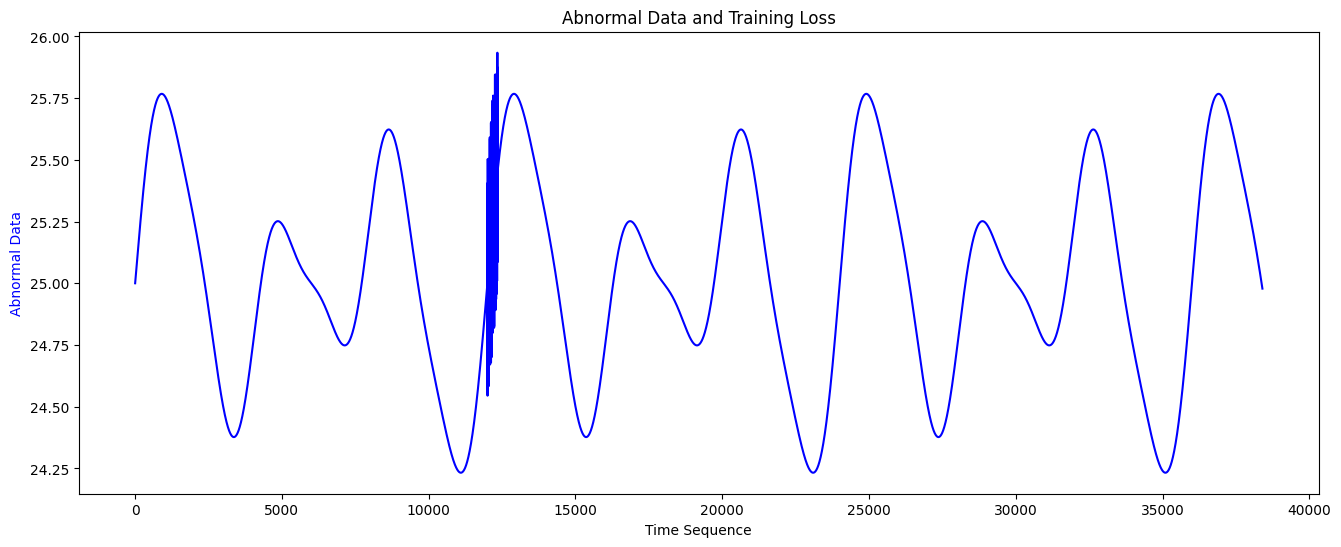

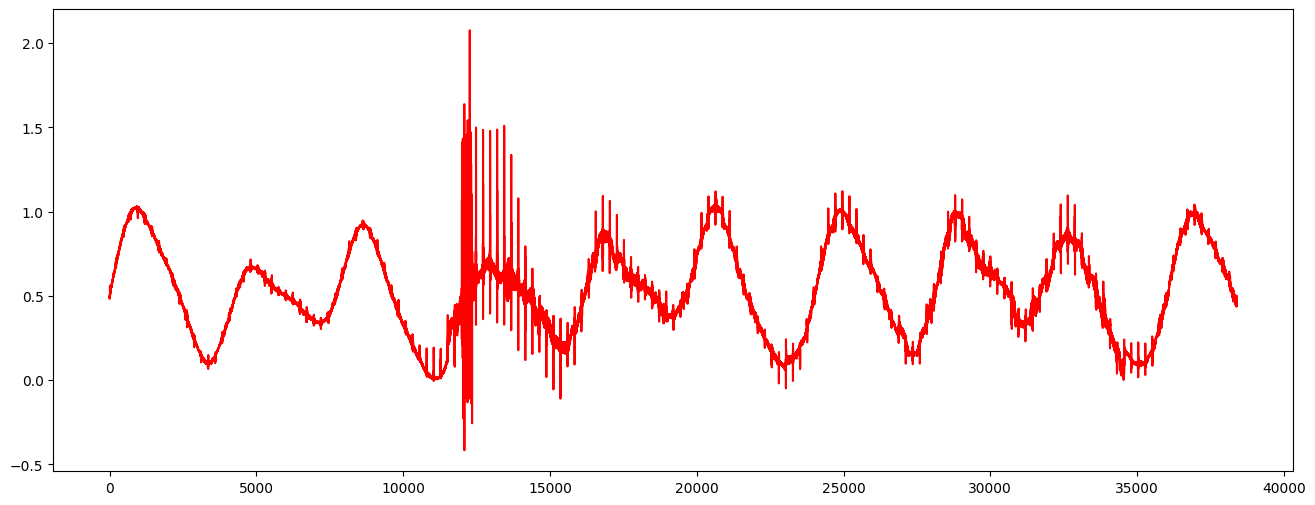

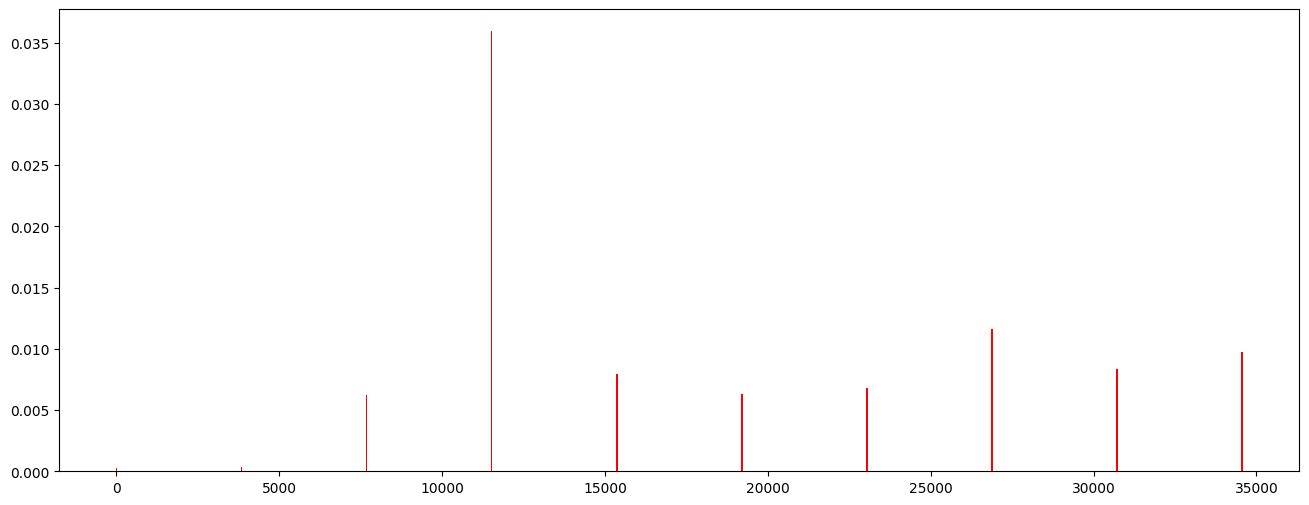

In [75]:
test_temp_rebuild = test_rebuild_result[0]
test_temp_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_temp_rebuild]
test_temp_rebuild = np.reshape(test_temp_rebuild_cpu, (-1, 1))

# test_humid_rebuild = test_rebuild_result[1]
# test_humid_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_humid_rebuild]
# test_humid_rebuild = np.reshape(test_humid_rebuild_cpu, (-1, 1))

# test_ammonia_rebuild = test_rebuild_result[2]
# test_ammonia_rebuild_cpu = [tensor.detach().cpu().numpy() for tensor in test_ammonia_rebuild]
# test_ammonia_rebuild = np.reshape(test_ammonia_rebuild_cpu, (-1, 1))
# temp_data = all_data[0]
# temp_min = np.min(temp_data)
# temp_max = np.max(temp_data)
# test_temp_rebuild = (temp_max - temp_min) * test_temp_rebuild + temp_min

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(test_temp_rebuild)), abnormal_data[:len(test_temp_rebuild)], 'b')
# ax1.plot(range(len(test_temp_rebuild)), test_temp_rebuild, 'r')
ax1.set_xlabel('Time Sequence')
ax1.set_ylabel('Abnormal Data', color='b')
plt.title('Abnormal Data and Training Loss')
plt.show()

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.plot(range(len(test_temp_rebuild)), test_temp_rebuild, 'r')
plt.show()

fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.bar(np.arange(0, len(test_temp_rebuild), batch_size*sequence_length), test_temp_loss, width=50, align='center', color='r', alpha=1)
plt.show()

In [70]:

# fig, ax1 = plt.subplots(figsize=(16, 6))
# ax1.plot(range(len(abnormal_data)), abnormal_data[:,1], 'b')
# ax1.plot(range(len(test_humid_rebuild)), test_humid_rebuild, 'r')
# ax1.set_xlabel('Time Sequence')
# ax1.set_ylabel('Abnormal Data', color='b')
# ax2 = ax1.twinx()
# ax2.bar(np.arange(batch_size - 1, batch_size * len(test_humid_loss), batch_size), test_humid_loss, width=5, align='center', color='r', alpha=0.5)
# ax2.set_ylabel('Abnormal Loss', color='r')
# plt.title('Abnormal Data and Training Loss')
# plt.show()

# fig, ax1 = plt.subplots(figsize=(16, 6))
# ax1.plot(range(len(abnormal_data)), abnormal_data[:,2], 'b')
# ax1.plot(range(len(test_ammonia_rebuild)), test_ammonia_rebuild, 'r')
# ax1.set_xlabel('Time Sequence')
# ax1.set_ylabel('Abnormal Data', color='b')
# ax2 = ax1.twinx()
# ax2.bar(np.arange(batch_size - 1, batch_size * len(test_ammonia_loss), batch_size), test_ammonia_loss, width=5, align='center', color='r', alpha=0.5)
# ax2.set_ylabel('Abnormal Loss', color='r')
# plt.title('Abnormal Data and Training Loss')
# plt.show()

In [71]:
print(model)

UNet(
  (down1): Down(
    (DConv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (DConv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): 